### Unsupervised Anomaly Detection in Healthcare Provider Claims

**Abstract**

Healthcare fraud detection is a critical challenge in ensuring the integrity of medical billing and insurance claims. This study leverages machine learning techniques to identify anomalies in healthcare provider claims using an unsupervised approach. The dataset is preprocessed and analyzed using Isolation Forest, One-Class SVM, and Local Outlier Factor (LOF) to detect fraudulent or unusual claim patterns. Principal Component Analysis (PCA) is employed to visualize anomalies in lower-dimensional space, providing insights into the data distribution.

**Objective**

1) Detect anomalies in healthcare provider claims using unsupervised learning techniques.
2) Compare performance of Isolation Forest, One-Class SVM, and LOF in anomaly detection.
3) Preprocess and encode categorical and numerical data for improved model accuracy.
4) Visualize anomaly scores and data distribution in 2D and 3D PCA projections.

**ML model Used**

Isolation Forest, One-Class SVM, Local Outlier Factor(LOF)

**Visualisation tool**

Histogram, 2D PCA scatter Plot, 3D PCA Plot

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Filter Warnings
import warnings

warnings.filterwarnings("ignore")

In [126]:
df = pd.read_csv('Healthcare Providers.csv')
df.head()

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,...,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,...,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,...,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,7594822,1770523540,FULLARD,JASPER,NaN,MD,M,I,5746 N BROADWAY ST,NaN,...,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,...,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758


In [127]:
drop_cols = ['index', 'National Provider Identifier',
             'Last Name/Organization Name of the Provider',
             'First Name of the Provider', 'Middle Initial of the Provider',
             'Street Address 1 of the Provider', 'Street Address 2 of the Provider',
             'Zip Code of the Provider']

df.drop(columns=drop_cols, inplace=True)

In [128]:
df['Credentials of the Provider'].fillna(df['Credentials of the Provider'].mode()[0], inplace=True)
df['Gender of the Provider'].fillna(df['Gender of the Provider'].mode()[0], inplace=True)

In [129]:
def remove_comma(x):
    return str(x).replace(',', '')

currency_cols = ['Average Medicare Allowed Amount', 'Average Medicare Payment Amount',
                 'Average Medicare Standardized Amount', 'Average Submitted Charge Amount']

for col in currency_cols:
    df[col] = pd.to_numeric(df[col].apply(remove_comma), errors='coerce')

In [130]:
cat_cols = df.select_dtypes(include=['object']).columns
encoder = ce.BinaryEncoder(cols=cat_cols)
df = encoder.fit_transform(df)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [137]:
iso_forest = IsolationForest(n_estimators=300, contamination=0.01, random_state=2020, verbose=1)
iso_forest.fit(df_scaled)
df['IF_Anomaly'] = iso_forest.predict(df_scaled)
df['IF_Anomaly'] = df['IF_Anomaly'].map({1: 0, -1: 1})  # Convert to 0 (normal) and 1 (anomaly)
df['IF_Anomaly_Score'] = iso_forest.decision_function(df_scaled)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.0s


In [138]:
svm = OneClassSVM(kernel="rbf", gamma='auto', nu=0.01)
svm.fit(df_scaled)
df['SVM_Anomaly'] = svm.predict(df_scaled)
df['SVM_Anomaly'] = df['SVM_Anomaly'].map({1: 0, -1: 1})
df['SVM_Anomaly_Score'] = svm.decision_function(df_scaled)

In [139]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(df_scaled)
df['LOF_Anomaly_Score'] = lof.decision_function(df_scaled)
df['LOF_Anomaly'] = lof.predict(df_scaled)
df['LOF_Anomaly'] = df['LOF_Anomaly'].map({1: 0, -1: 1})

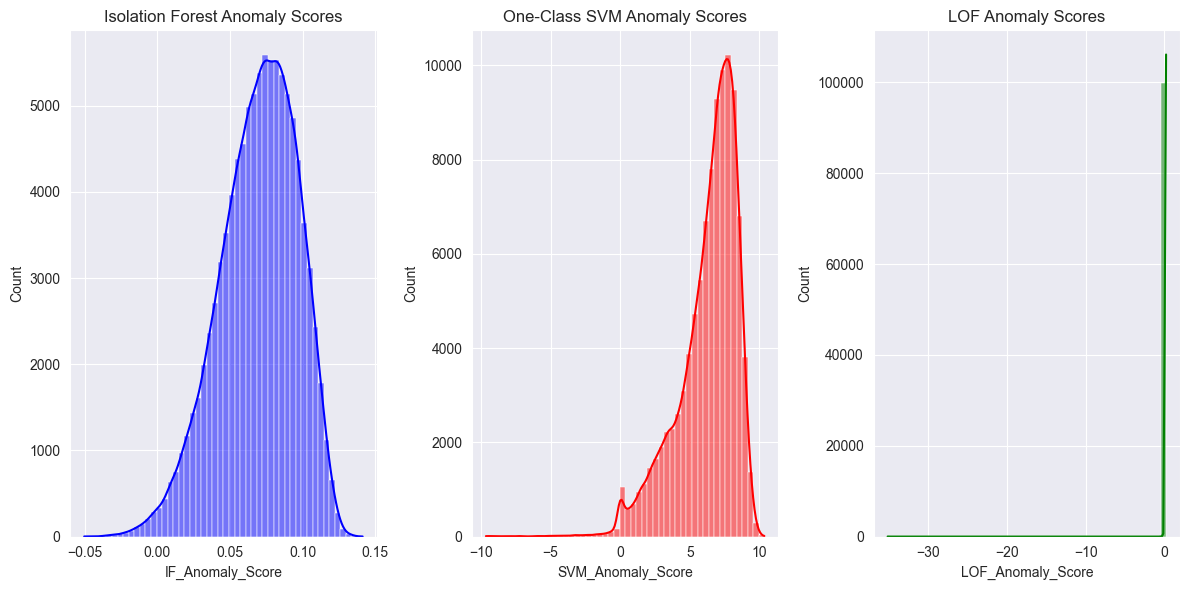

In [140]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(df['IF_Anomaly_Score'], bins=50, kde=True, color='blue')
plt.title("Isolation Forest Anomaly Scores")

plt.subplot(1, 3, 2)
sns.histplot(df['SVM_Anomaly_Score'], bins=50, kde=True, color='red')
plt.title("One-Class SVM Anomaly Scores")

plt.subplot(1, 3, 3)
sns.histplot(df['LOF_Anomaly_Score'], bins=50, kde=True, color='green')
plt.title("LOF Anomaly Scores")

plt.tight_layout()
plt.show()

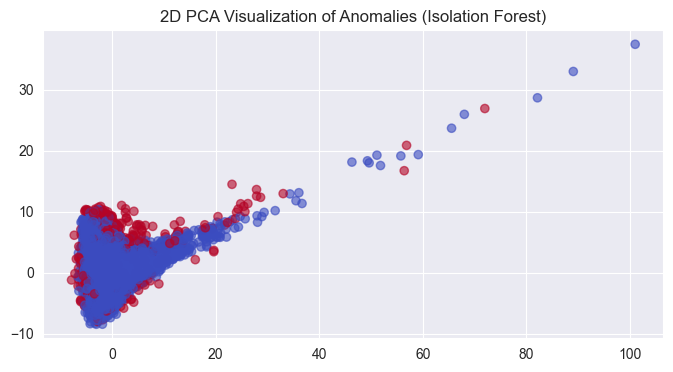

In [141]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 4))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.6, c=df['IF_Anomaly'], cmap='coolwarm')
plt.title('2D PCA Visualization of Anomalies (Isolation Forest)')
plt.show()

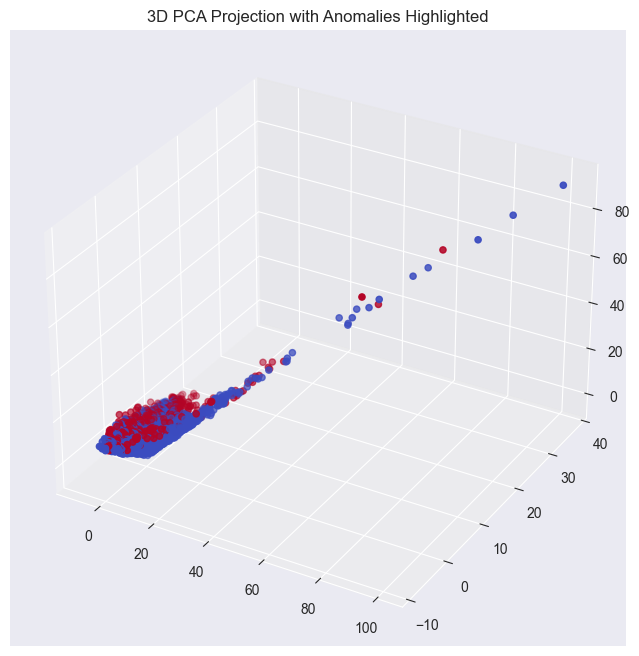

In [142]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(x_pca, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df['Anomaly'], cmap='coolwarm', marker="o")
ax.set_title("3D PCA Projection with Anomalies Highlighted")
plt.show()

In [143]:
print("Anomaly Counts per Method:")
print(df[['IF_Anomaly', 'SVM_Anomaly', 'LOF_Anomaly']].sum())

Anomaly Counts per Method:
IF_Anomaly     1000
SVM_Anomaly    1030
LOF_Anomaly     763
dtype: int64
